<a href="https://colab.research.google.com/github/toraaglobal/SREIT/blob/master/06_EDA_and_Picking_Top_Zip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reccommending The Top3 Zipcode For The Best Investment Oppotunity For SREIT

## Import Packages and Mount drive

In [1]:
%%bash

sudo apt-get install libgeos-3.5.0
sudo apt-get install libgeos-dev
sudo pip install https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 5s (14.2 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 130824 files and directories currently installed.)
Preparing to unpack .../libgeos-dev_3.6.2-1build2_amd64.deb ...
Unpacking libgeos-dev (3.6.2-1build2) ...
Setting up libgeos-dev (3.6.2-1build2) ...
Processing triggers for ma

E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import sqlite3
import pickle
import datetime as dt
from sklearn.metrics import mean_squared_error
## 

from mpl_toolkits.basemap import Basemap


%matplotlib inline

In [3]:
#Mount the gdrive
import os
from google.colab import drive
drive.mount('/content/drive')


#change directry to the gdrive

os.chdir('./drive/My Drive/Colab Notebooks/code')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Connect to Model database

In [0]:

## create a database connection
conn = sqlite3.connect('uszipmodel.sqlite')
cur = conn.cursor()

### Load datasets from drive

In [5]:
## Read data

single_family = pd.read_csv('single_family_prep.csv')
single_family.head()

,Unnamed: 0,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,Values
0,0,60657,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,1,1996-04-01,337200.0
1,1,77494,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,2,1996-04-01,210400.0
2,2,60614,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,3,1996-04-01,502900.0
3,3,77449,77449,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,1996-04-01,95400.0
4,4,79936,79936,El Paso,TX,El Paso,El Paso County,5,1996-04-01,77300.0


In [6]:
single_family.shape

(4272756, 10)

In [7]:

## Rename zipcode
single_family = single_family.rename(index=str, columns={'RegionName': "Zipcode"})
single_family['Date'] = pd.to_datetime(single_family['Date'])

## Data type convertion
single_family['Zipcode'] = single_family['Zipcode'].astype(str)
single_family['RegionID'] = single_family['RegionID'].astype(str)

single_family.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4272756 entries, 0 to 4272755
Data columns (total 10 columns):
Unnamed: 0    int64
RegionID      object
Zipcode       object
City          object
State         object
Metro         object
CountyName    object
SizeRank      int64
Date          datetime64[ns]
Values        float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 358.6+ MB


## EDA

Below is the top 20 zipcodes with the highest rate of return according to the article on USTODAY

**Top20 Zicode with the Highest Rate of Return**

Source : `https://www.usatoday.com/story/money/personalfinance/2017/07/31/20-zip-codes-highest-real-estate-returns/516281001/`


1.  33434 : 8.1% 
1. 19035: 6.9%
1. 48322: 6.9%
1. 33158 : 6.8%
1. 33327: 6.6%
1. 37062: 6.5%
1. 66223: 6.2%
1. 60016: 6%
1. 45255: 5.9%
1. 30078: 5.8%
1. 97224: 5.8%
1. 34677: 5.7%
1. 44023: 5.6%
1. 75022: 5.6%
1. 77059: 5.6%
1. 85259: 5.5%
1. 63043: 5.5%
1. 73003: 5.4%
1. 91602: 5.4%
1. 46280: 5.4%


### Lets check the trend and volatility of the following zipcodes

In [0]:
## Top 20 zipcodes with the highest rate of annual return
top20_zips = ['33434', '19035', '48322','33158', '33327','37062','66223','60016','45255','30078','97224','34677','44023','75022','77059','85259','63043','73003','91602','46280']


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


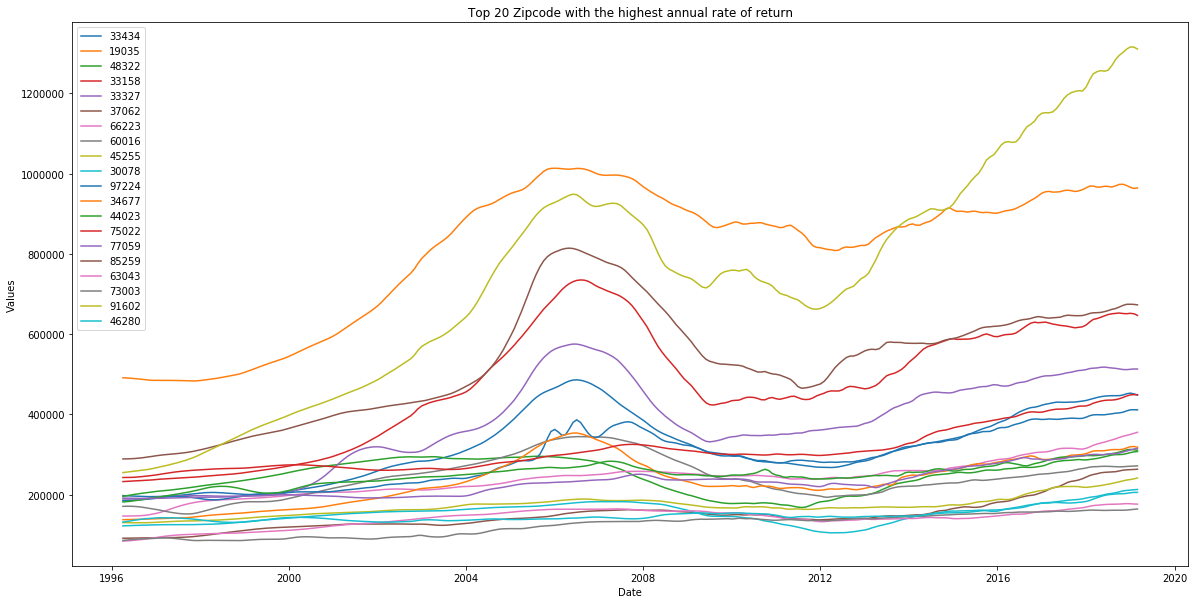

In [9]:

## Explore
plt.figure(figsize=(20,10))
for zip in top20_zips:
  ax = sns.lineplot('Date', 'Values',label = zip, data= single_family[single_family['Zipcode'] ==  zip])
plt.title("Top 20 Zipcode with the highest annual rate of return")
plt.show()

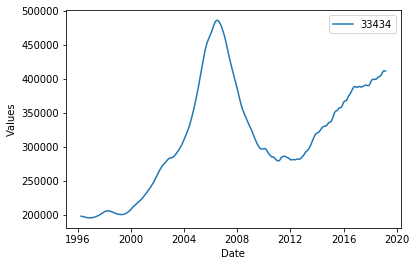

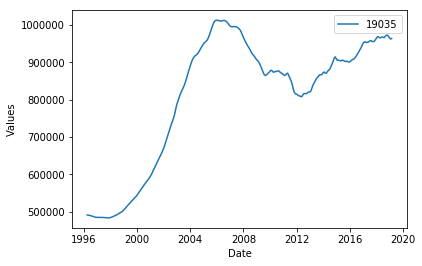

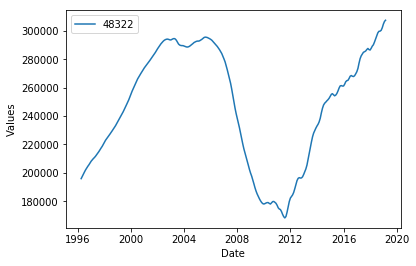

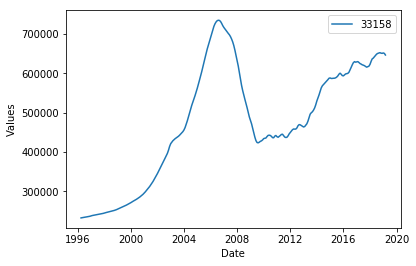

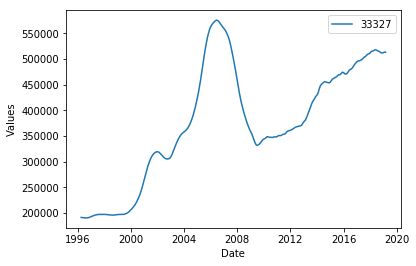

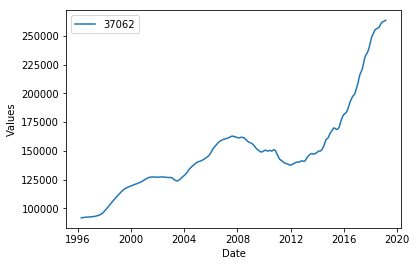

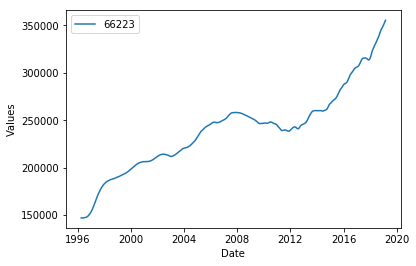

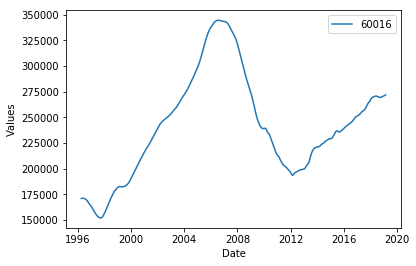

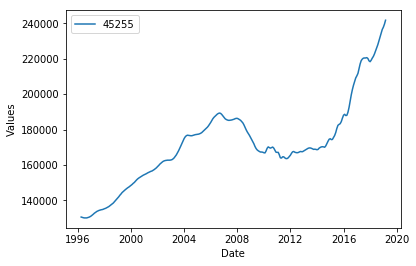

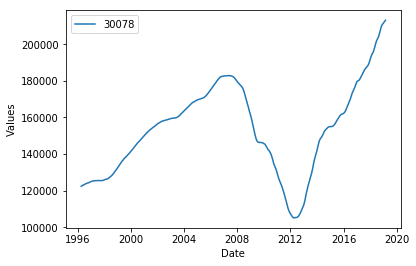

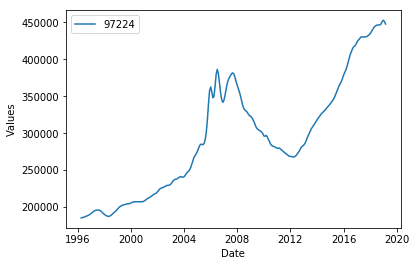

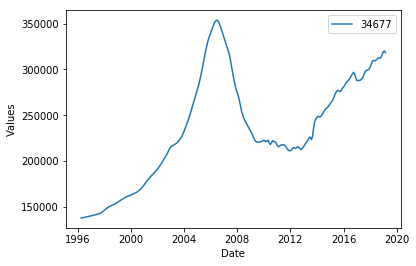

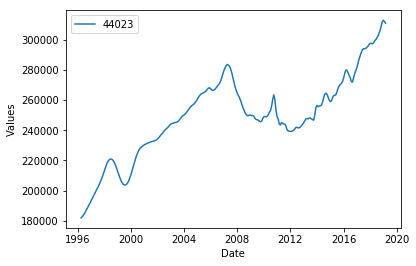

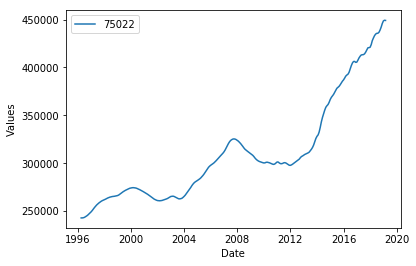

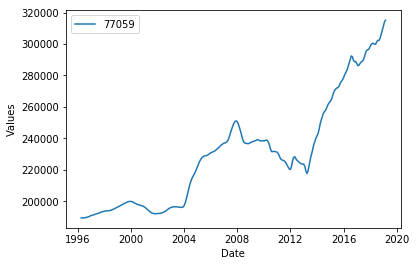

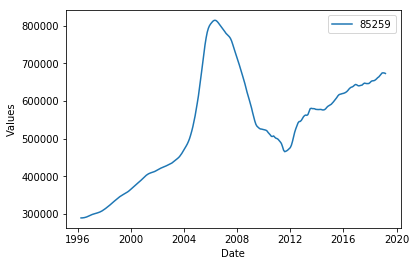

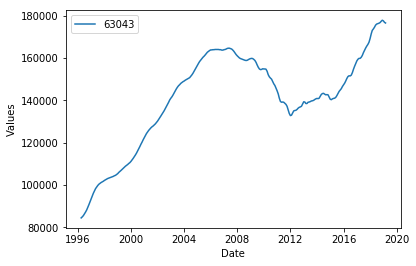

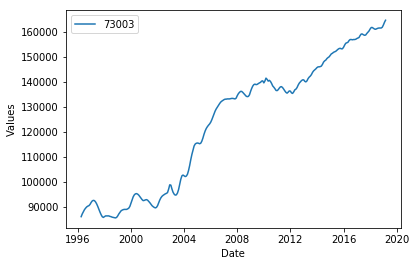

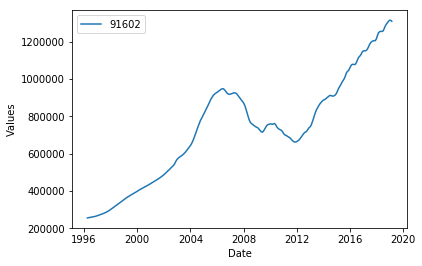

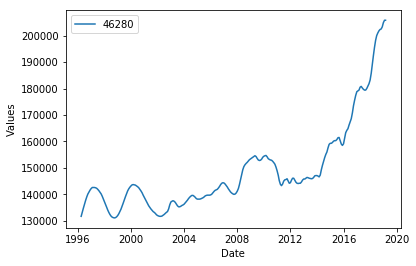

In [0]:

## Explore

for zip in top20_zips:
  ax = sns.lineplot('Date', 'Values',label = zip, data= single_family[single_family['Zipcode'] ==  zip])
  plt.show()
           


In [0]:

top_10 = ['33434', '19035', '48322','33158', '33327','37062','66223','60016','45255','30078']

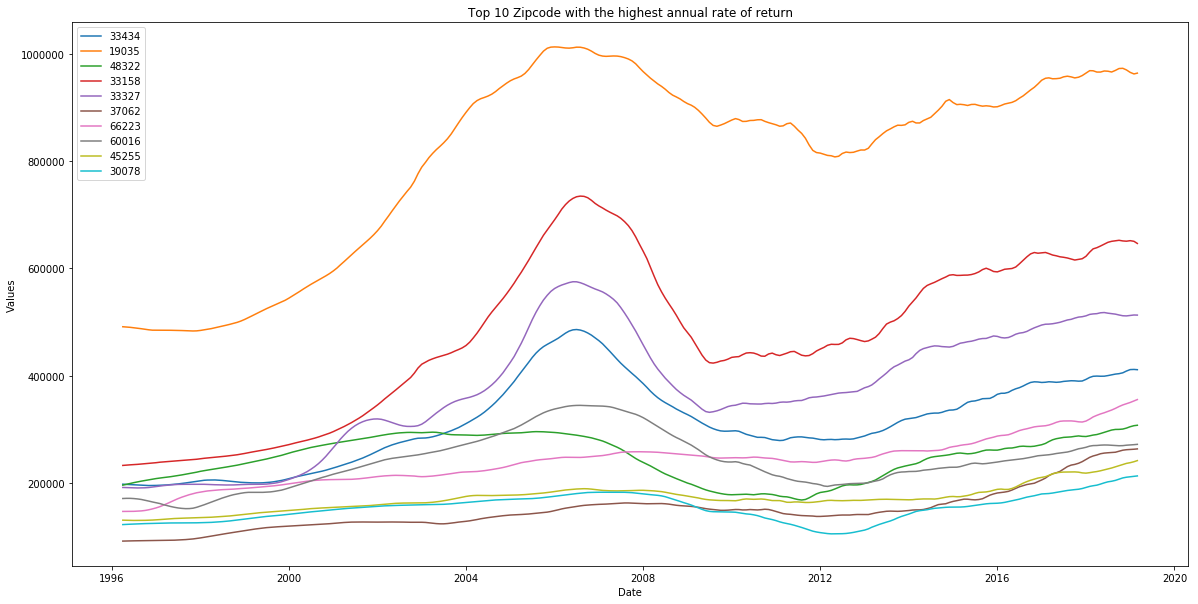

In [11]:
plt.figure(figsize=(20,10))
for zip in top_10:
  ax = sns.lineplot('Date', 'Values',label = zip, data= single_family[single_family['Zipcode'] ==  zip])
plt.title("Top 10 Zipcode with the highest annual rate of return")
plt.show()

## Load datasets with geometry created from the r-scripts 

In [12]:
new_df = pd.read_csv('single_family_with_geo.csv')
new_df.head()

,Unnamed: 0,State,RegionName,X,RegionID,City,Metro,CountyName,SizeRank,Date,Values,year,month,city,state,latitude,longitude,statename
0,1,AK,99501,3380471,99501,Anchorage,Anchorage,Anchorage Borough,5614,2014-06-01,339600.0,2014,6,Anchorage,AK,61.216799,-149.87828,Alaska
1,2,AK,99501,857068,99501,Anchorage,Anchorage,Anchorage Borough,5614,2000-11-01,163500.0,2000,11,Anchorage,AK,61.216799,-149.87828,Alaska
2,3,AK,99501,1739485,99501,Anchorage,Anchorage,Anchorage Borough,5614,2005-08-01,265300.0,2005,8,Anchorage,AK,61.216799,-149.87828,Alaska
3,4,AK,99501,2977965,99501,Anchorage,Anchorage,Anchorage Borough,5614,2012-04-01,313500.0,2012,4,Anchorage,AK,61.216799,-149.87828,Alaska
4,5,AK,99501,2714788,99501,Anchorage,Anchorage,Anchorage Borough,5614,2010-11-01,320800.0,2010,11,Anchorage,AK,61.216799,-149.87828,Alaska


In [31]:
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3865932 entries, 0 to 3865931
Data columns (total 18 columns):
Unnamed: 0    int64
State         object
RegionName    int64
X             int64
RegionID      int64
City          object
Metro         object
CountyName    object
SizeRank      int64
Date          datetime64[ns]
Values        float64
year          int64
month         int64
city          object
state         object
latitude      float64
longitude     float64
statename     object
dtypes: datetime64[ns](1), float64(3), int64(7), object(7)
memory usage: 530.9+ MB


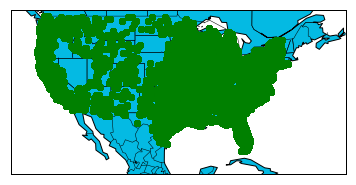

In [18]:
## basemap
plt.figure()

m = Basemap(projection='mill', llcrnrlat= 20, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-60, resolution='c')

m.drawcoastlines()
m.drawstates()
m.drawcountries()
m.fillcontinents(color='#04BAE3', lake_color='#FFFFFF')
m.drawmapboundary(fill_color='#FFFFFF')

lat, lon = new_df['latitude'].values, new_df['longitude'].values

x,y = m(lon,lat)

m.plot(x,y,'go')
plt.show()

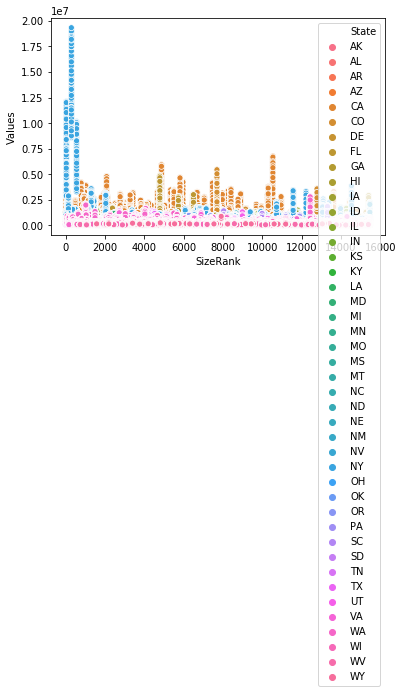

In [21]:
sns.scatterplot(new_df.SizeRank, new_df.Values, hue=new_df.State)

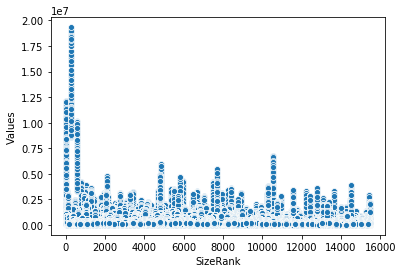

In [22]:
sns.scatterplot(new_df.SizeRank, new_df.Values)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([3.195000e+03, 1.055070e+05, 1.071203e+06, 1.607711e+06,
        6.665130e+05, 1.978300e+05, 3.023900e+04, 6.497000e+03,
        6.080000e+02, 2.630000e+02]),
 array([ 9.32366906, 10.06906093, 10.81445281, 11.55984468, 12.30523655,
        13.05062843, 13.7960203 , 14.54141218, 15.28680405, 16.03219593,
        16.7775878 ]),
 <a list of 10 Patch objects>)

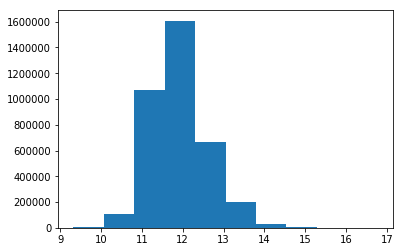

In [26]:
plt.hist(np.log(new_df.Values))

In [38]:
## Group by metro

df_metro = new_df.groupby(['Metro', 'Date']).median().reset_index()
df_metro.head()

,Metro,Date,Unnamed: 0,RegionName,X,RegionID,SizeRank,Values,year,month,latitude,longitude
0,Aberdeen,1996-04-01,3681584.0,98553.5,10544.0,98553.5,10545.0,96100.0,1996.0,4.0,46.978421,-123.754965
1,Aberdeen,1996-05-01,3681614.0,98553.5,26025.0,98553.5,10545.0,96100.0,1996.0,5.0,46.978421,-123.754965
2,Aberdeen,1996-06-01,3681482.0,98553.5,41506.0,98553.5,10545.0,96050.0,1996.0,6.0,46.978421,-123.754965
3,Aberdeen,1996-07-01,3681544.5,98553.5,56987.0,98553.5,10545.0,96050.0,1996.0,7.0,46.978421,-123.754965
4,Aberdeen,1996-08-01,3681493.0,98553.5,72468.0,98553.5,10545.0,96000.0,1996.0,8.0,46.978421,-123.754965


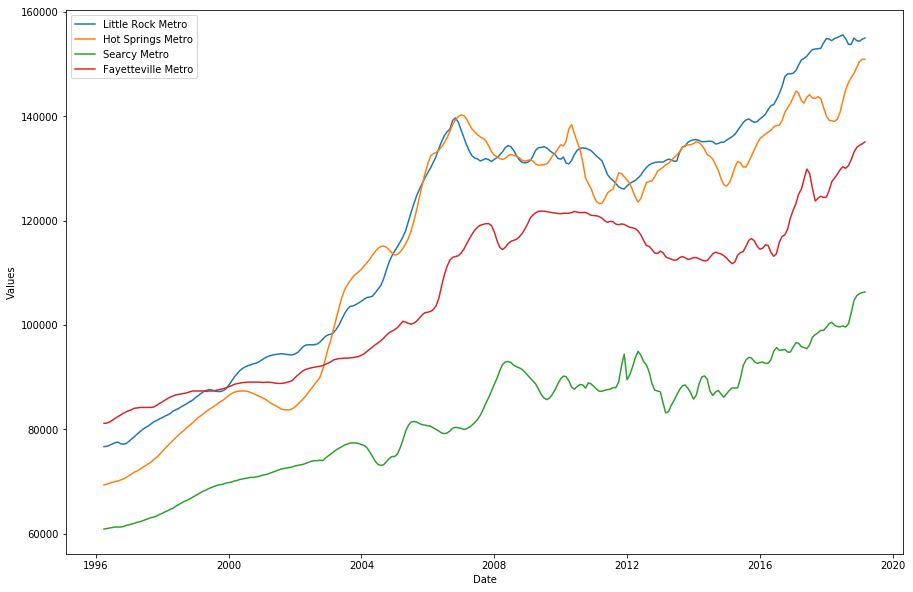

In [39]:

## 
plt.figure(figsize= (15,10))

#ax = sns.lineplot(x="Date", y="Values",label='Ada Metro',data=df_metro.query("Metro == 'Ada'"))
ax = sns.lineplot(x="Date", y="Values",label='Little Rock Metro',data=df_metro.query("Metro == 'Little Rock-North Little Rock-Conway'"))
ax = sns.lineplot(x="Date", y="Values",label='Hot Springs Metro',data=df_metro.query("Metro == 'Hot Springs'"))
ax = sns.lineplot(x="Date", y="Values",label='Searcy Metro',data=df_metro.query("Metro == 'Searcy'"))
ax = sns.lineplot(x="Date", y="Values",label='Fayetteville Metro',data=df_metro.query("Metro == 'Fayetteville'"))


plt.show()

In [0]:
cur.execute('SELECT zip, mse from models_log')

data = cur.fetchall()

In [41]:
df_mse = pd.DataFrame(data = data, columns=['zip','mse'])
df_mse.head()

,zip,mse
0,60657,0.000149
1,77494,0.001895
2,60614,0.000154
3,77449,0.003275
4,79936,0.001303


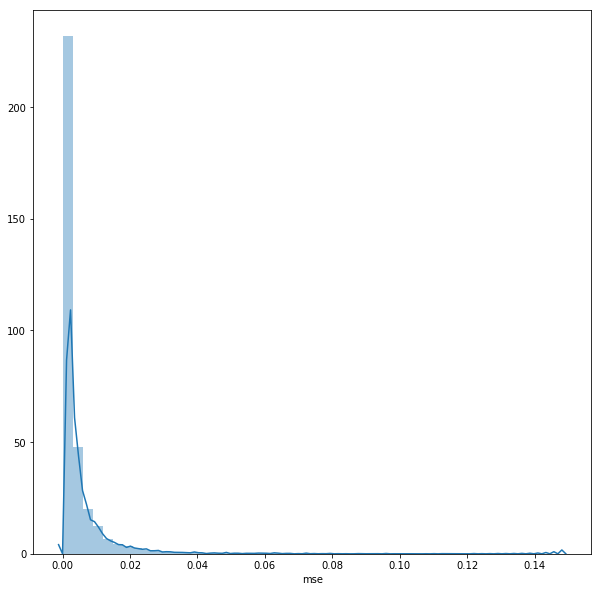

In [42]:
plt.figure(figsize = (10,10))
sns.distplot(df_mse['mse'])
plt.show()